In [4]:
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
import math

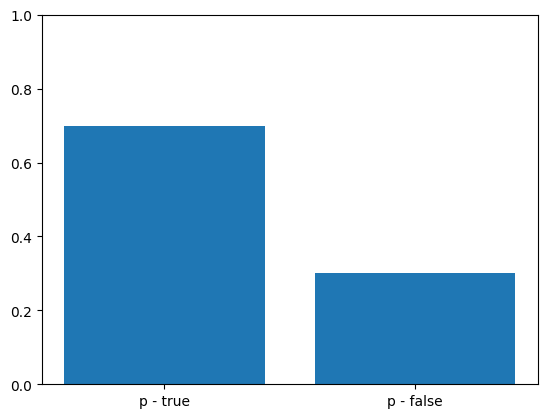

In [2]:
p=0.7

fig, ax = plt.subplots()

ax.bar(['p - true', 'p - false'], [p, 1-p])
ax.set_ylim(0, 1)
plt.show()

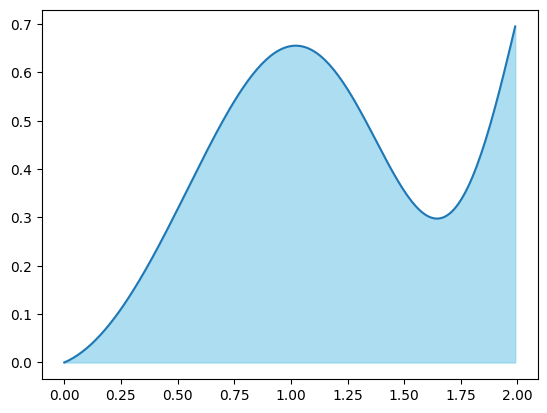

In [28]:
def f(x): 
    return math.sin(x**2) * math.cos(x) + 0.2 * x

h = 0.01
x1 = 2
x0 = 0
X = [x0+h*k for k in range(int((x1-x0)/h))]
Y = [f(x) for x in X]

plt.fill_between(X, Y, color='skyblue', alpha=0.69)
plt.plot(X, Y)
plt.show()

the area is 0.8098


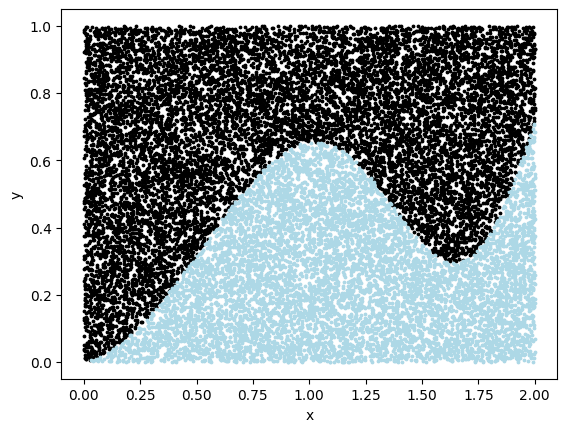

In [37]:
number_samples = 20_000

samples_in = []
samples_out = []

for i in range(number_samples):
    x = rnd.random() * (x1-x0) + x0
    y = rnd.random()
    if y < f(x):
        samples_in.append((x,y))
    else:
        samples_out.append((x,y))

print(f"the area is {len(samples_in)/number_samples*(x1-x0)}")

# plot the samples - blue for in, red for out

x_samplesIn = [p[0] for p in samples_in]
y_samplesIn = [p[1] for p in samples_in]

x_samplesOut = [p[0] for p in samples_out]
y_samplesOut = [p[1] for p in samples_out]

plt.scatter(x_samplesOut, y_samplesOut, color='black', s=3)
plt.scatter(x_samplesIn, y_samplesIn, color='lightblue', s=3)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Training with Exact Hessian:
Iteration 1/20 | Train Loss: 275.8725 | Test Loss: 105.5684 | Test Acc: 92.98%
Iteration 2/20 | Train Loss: 245.3013 | Test Loss: 95.1507 | Test Acc: 92.98%
Iteration 3/20 | Train Loss: 220.1727 | Test Loss: 86.5554 | Test Acc: 93.57%
Iteration 4/20 | Train Loss: 199.0357 | Test Loss: 79.3190 | Test Acc: 93.57%
Iteration 5/20 | Train Loss: 180.9536 | Test Loss: 73.1233 | Test Acc: 93.57%
Iteration 6/20 | Train Loss: 165.2697 | Test Loss: 67.7510 | Test Acc: 93.57%
Iteration 7/20 | Train Loss: 151.5244 | Test Loss: 63.0475 | Test Acc: 93.57%
Iteration 8/20 | Train Loss: 139.3819 | Test Loss: 58.8956 | Test Acc: 93.57%
Iteration 9/20 | Train Loss: 128.5798 | Test Loss: 55.2047 | Test Acc: 93.57%
Iteration 10/20 | Train Loss: 118.9119 | Test Loss: 51.9086 | Test Acc: 93.57%
Iteration 11/20 | Train Loss: 110.2240 | Test Loss: 48.9519 | Test Acc: 93.57%
Iteration 12/20 | Train Loss: 102.3840 | Test Loss: 46.2893 | Test Acc: 93.57%
Iteration 13/20 | Train Loss: 9

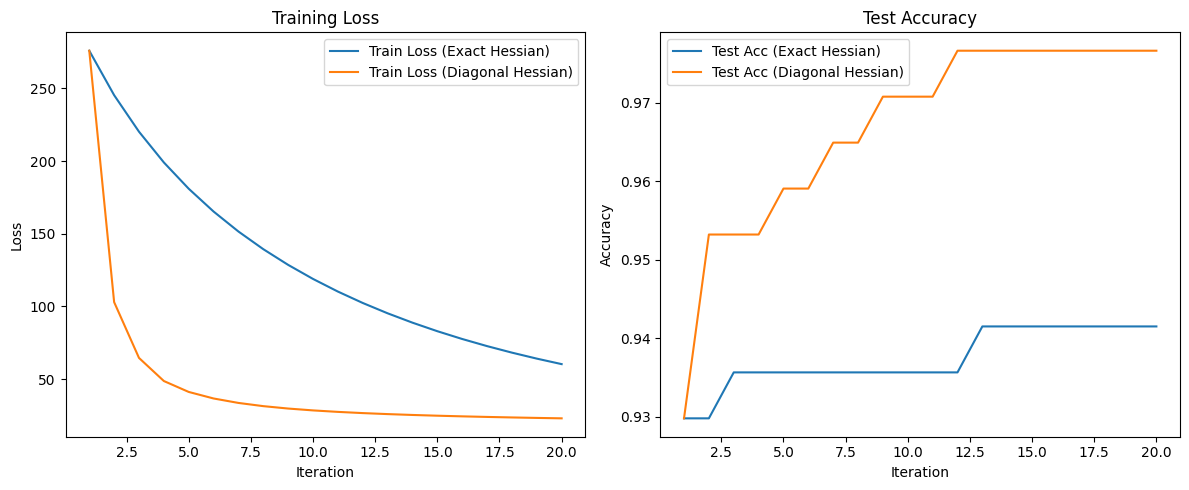

In [39]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# 1. Load and Preprocess the Data
def load_data(test_size=0.3):
    data = load_breast_cancer()
    X = data['data']  # Features
    y = data['target']  # Labels (0 or 1)
    
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Add intercept term
    X = np.hstack((np.ones((X.shape[0], 1)), X))  # Shape: (N, D)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)  # Shape: (N_train, D)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Shape: (N_train, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)    # Shape: (N_test, D)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)    # Shape: (N_test, 1)
    
    return X_train, X_test, y_train, y_test

# 2. Define Helper Functions
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

def compute_loss(X, y, w):
    z = X @ w
    loss = -torch.sum(y * torch.log(sigmoid(z) + 1e-15) + (1 - y) * torch.log(1 - sigmoid(z) + 1e-15))
    return loss

def compute_accuracy(X, y, w):
    with torch.no_grad():
        z = X @ w
        preds = sigmoid(z) >= 0.5
        correct = (preds.float() == y).sum().item()
        accuracy = correct / y.shape[0]
    return accuracy

# 3. Implement Newton's Method
def newtons_method(X_train, y_train, X_test, y_test, 
                  max_iters=20, lr=0.1, hessian_type='exact'):
    """
    hessian_type: 'exact' or 'diagonal'
    """
    N, D = X_train.shape
    w = torch.zeros((D, 1), dtype=torch.float32, requires_grad=True)  # Initialize weights
    
    train_losses = []
    test_losses = []
    test_accuracies = []
    
    for it in range(max_iters):
        # Zero gradients
        if w.grad is not None:
            w.grad.zero_()
        
        # Compute loss
        loss = compute_loss(X_train, y_train, w)
        train_losses.append(loss.item())
        
        # Compute gradient
        loss.backward()
        grad = w.grad.clone()  # Shape: (D, 1)
        
        # Compute Hessian
        with torch.no_grad():
            z = X_train @ w  # Shape: (N, 1)
            probs = sigmoid(z)  # Shape: (N, 1)
            W_diag = probs * (1 - probs)  # Shape: (N, 1)
            W = torch.diagflat(W_diag.squeeze())  # Shape: (N, N)
            H = X_train.t() @ W @ X_train  # Shape: (D, D)
            
            if hessian_type == 'diagonal':
                H = torch.diag(torch.diag(H))
            
            # Invert Hessian
            try:
                H_inv = torch.inverse(H)
            except RuntimeError:
                print("Hessian is singular. Stopping optimization.")
                break
            
            # Update weights
            w_update = H_inv @ grad  # Shape: (D, 1)
            w = w - lr * w_update
            w = w.detach().requires_grad_(True)
        
        # Compute loss and accuracy on test set
        test_loss = compute_loss(X_test, y_test, w).item()
        test_losses.append(test_loss)
        accuracy = compute_accuracy(X_test, y_test, w)
        test_accuracies.append(accuracy)
        
        # Print progress
        print(f"Iteration {it+1}/{max_iters} | Train Loss: {loss.item():.4f} | Test Loss: {test_loss:.4f} | Test Acc: {accuracy*100:.2f}%")
    
    return train_losses, test_losses, test_accuracies

# 4. Train Models and Plot Results
def train_and_plot():
    X_train, X_test, y_train, y_test = load_data(test_size=0.3)
    
    # Exact Hessian
    print("Training with Exact Hessian:")
    train_losses_exact, test_losses_exact, test_acc_exact = newtons_method(
        X_train, y_train, X_test, y_test, 
        max_iters=20, lr=0.1, hessian_type='exact'
    )
    
    # Diagonal Hessian
    print("\nTraining with Diagonal Hessian:")
    train_losses_diag, test_losses_diag, test_acc_diag = newtons_method(
        X_train, y_train, X_test, y_test, 
        max_iters=20, lr=0.1, hessian_type='diagonal'
    )
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses_exact)+1), train_losses_exact, label='Train Loss (Exact Hessian)')
    plt.plot(range(1, len(train_losses_diag)+1), train_losses_diag, label='Train Loss (Diagonal Hessian)')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(test_acc_exact)+1), test_acc_exact, label='Test Acc (Exact Hessian)')
    plt.plot(range(1, len(test_acc_diag)+1), test_acc_diag, label='Test Acc (Diagonal Hessian)')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Execute the training and plotting
train_and_plot()


In [42]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Define the Custom MNIST Dataset
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file containing MNIST data.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.labels = self.data['label'].values
        self.images = self.data.drop('label', axis=1).values.astype(np.float32)
        self.images = self.images / 255.0  # Normalize pixel values to [0, 1]
        self.images = self.images.reshape(-1, 1, 28, 28)  # Reshape to (N, C, H, W)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return torch.tensor(image), torch.tensor(label)

# 2. Instantiate the Dataset and DataLoader
def load_mnist_dataset(csv_path, batch_size=8, shuffle=True):
    dataset = MNISTDataset(csv_file=csv_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

# 3. Visualize a Batch of 8 Images and Labels
def visualize_batch(dataloader):
    # Get one batch
    images, labels = next(iter(dataloader))
    
    # Plotting
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    for img, label, ax in zip(images, labels, axes):
        img = img.squeeze().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Label: {label.item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 4. Example Usage
if __name__ == "__main__":
    # Path to the MNIST CSV file
    csv_path = 'mnist_train.csv'  # Update this path to where you've downloaded the CSV
    
    # Check if the file exists
    if not os.path.exists(csv_path):
        print(f"CSV file not found at {csv_path}. Please download it from Kaggle and place it accordingly.")
    else:
        # Load DataLoader
        dataloader = load_mnist_dataset(csv_path, batch_size=8, shuffle=True)
        
        # Visualize a batch
        visualize_batch(dataloader)


CSV file not found at mnist_train.csv. Please download it from Kaggle and place it accordingly.


Defaulting to user installation because normal site-packages is not writeable
  Using cached albumentations-1.4.16-py3-none-any.whl.metadata (38 kB)
  Using cached albucore-0.0.17-py3-none-any.whl.metadata (3.1 kB)
  Using cached eval_type_backport-0.2.0-py3-none-any.whl.metadata (2.2 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
Using cached albumentations-1.4.16-py3-none-any.whl (214 kB)
Using cached albucore-0.0.17-py3-none-any.whl (10 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl (54.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 22.6 MB/s eta 0:00:0000:0100:01
Using cached eval_type_backport-0.2.0-py3-none-any.whl (5.9 kB)
Note: you may need to restart the kernel to use updated packages.


/Users/yd211/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/yd211/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Images directory or masks directory not found. Please ensure the paths are correct.
